# 08-Road Network Analysis

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import networkx as nx
import folium
import os
import json

from itertools import pairwise
from geo.road import RoadNetwork, download_road_network, download_road_network_bbox
from geo.trajectory import load_trajectory_points
from geo.math import vec_haversine
from folium.vector_layers import PolyLine, CircleMarker

In [2]:
n, s, e, w = 42.325853, 42.220268, -83.673437, -83.804839
dv = n - s
dh = e - w

In [3]:
delta = 0.5

In [4]:
dh

0.13140199999999425

In [5]:
n = n + dv * delta
s = s - dv * delta
e = e + dh * delta
w = w - dh * delta

In [6]:
n, s, e, w

(42.378645500000005, 42.167475499999995, -83.60773600000002, -83.87054)

In [7]:
rn = download_road_network_bbox(n, s, e, w, 
                               custom_filter='["highway"~"motorway|trunk|primary|secondary|tertiary|residential|motorway_link|trunk_link|primary_link|secondary_link|tertiary_link"]')

In [8]:
road_network = RoadNetwork(rn)

In [9]:
nx.number_connected_components(nx.to_undirected(rn))

89

In [10]:
trajectory_id = 4 # 13

In [11]:
trajectory = load_trajectory_points(trajectory_id, unique=True)

In [12]:
def match_edges(road_network, trajectory):
    edges = []
    unique_locations = set()
    edge_set = set()
    for p in trajectory:
        if p not in unique_locations:
            e = road_network.get_matching_edge(*p, min_r=1.0)
            if e is not None:
                n0, n1, _ = e
                edge = (n0, n1)
                if edge not in edge_set:
                    edge_set.add(edge)
                    edges.append(edge)
                unique_locations.add(p)
    return edges

In [13]:
def build_path(rn, edges):
    path = []
    for e0, e1 in pairwise(edges):
        if not len(path):
            path.append(e0[0])
        if e0[0] != e1[0] and e0[1] != e1[1]:
            if e0[1] == e1[0]:
                path.extend([e0[1], e1[1]])
            else:
                n0, n1 = int(e0[1]), int(e1[0])
                sp = ox.distance.shortest_path(rn, n0, n1)
                if sp is not None:
                    path.extend(sp[1:])
    return path

In [14]:
edges = match_edges(road_network, trajectory)

In [15]:
path = build_path(rn, edges)

In [16]:
len(path)

260

In [17]:
def fit_bounding_box(html_map, bb_list):
    if isinstance(bb_list, list):
        ll = np.array(bb_list)
    else:
        ll = bb_list
        
    min_lat, max_lat = ll[:, 0].min(), ll[:, 0].max()
    min_lon, max_lon = ll[:, 1].min(), ll[:, 1].max()
    html_map.fit_bounds([[min_lat, min_lon], [max_lat, max_lon]])
    return html_map

In [18]:
def map_trajectory(trajectory):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)

    line = [(t[0], t[1]) for t in trajectory]
        
    PolyLine(line, weight=3, opacity=0.5).add_to(html_map)
        
    return fit_bounding_box(html_map, line)

In [19]:
map_trajectory(trajectory)

In [20]:
def map_edges(rn, edges, trajectory=None):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=20, control_scale=True)
    
    bb_list = []
    
    for edge in edges:
        n0 = rn.nodes[edge[0]]
        n1 = rn.nodes[edge[1]]
        line = [(n0['y'], n0['x']), (n1['y'], n1['x'])]
        PolyLine(line, weight=3, opacity=0.5, popup=edge[0]).add_to(html_map)
        bb_list.extend(line)
        
    if trajectory:
        for p in trajectory:
            CircleMarker((p[0], p[1]), color="red", opacity=0.5, radius=2, popup=f"({p[0]}, {p[1]})").add_to(html_map)

    return fit_bounding_box(html_map, bb_list)

In [21]:
map_edges(rn, edges, trajectory)

In [22]:
def map_nearest_edges(rn, latitude, longitude):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=21, control_scale=True)
    bb_list = []
    
    loc = np.array([latitude, longitude])
    _, r = rn.geo_spoke.query_knn(loc, 1)
    radius = rn.max_edge_length + r[0]
    node_idx, dists = rn.geo_spoke.query_radius(loc, radius)
    nodes = rn.ids[node_idx]
    
    for node in nodes:
        n = rn.graph.nodes[node]
        bb_list.append((n['y'], n['x']))
        CircleMarker((n['y'], n['x']), color="red", opacity=0.5, radius=2, popup=f"{n['y']}, {n['x']}").add_to(html_map)
    # CircleMarker((latitude, longitude), color="blue", opacity=0.5, radius=4, popup=f"({latitude}, {longitude})").add_to(html_map)
    return fit_bounding_box(html_map, bb_list)

In [23]:
# map_nearest_edges(rnx, 42.244542, -83.714397)

In [24]:
map_trajectory([(rn.nodes[p]['y'], rn.nodes[p]['x']) for p in path])

In [25]:
def map_edge_path(rn, path, trajectory=None):
    html_map = folium.Map(prefer_canvas=True, tiles="cartodbpositron", max_zoom=21, control_scale=True)
    
    line = [(rn.nodes[n]['y'], rn.nodes[n]['x']) for n in path]
    PolyLine(line, weight=3, opacity=0.5).add_to(html_map)
        
    if trajectory:
        for p in trajectory:
            CircleMarker((p[0], p[1]), color="red", opacity=0.5, radius=2, popup=f"({p[0]}, {p[1]})").add_to(html_map)

    return fit_bounding_box(html_map, line)

In [26]:
map_edge_path(rn, path, trajectory)

In [27]:
# map_edge_path(rn, path[20:35], trajectory)

In [28]:
def calculate_difference(rn, path, trajectory):
    p_loc = np.array([(rn.nodes[n]['y'], rn.nodes[n]['x']) for n in path])
    t_loc = np.array([(t[0], t[1]) for t in trajectory])
    
    p_length = vec_haversine(p_loc[1:, 0], p_loc[1:, 1], p_loc[:-1, 0], p_loc[:-1, 1]).sum()
    t_length = vec_haversine(t_loc[1:, 0], t_loc[1:, 1], t_loc[:-1, 0], t_loc[:-1, 1]).sum()
    return p_length - t_length

In [29]:
calculate_difference(rn, path, trajectory)

28.12708031469083

In [30]:
def load_state(filename="./state.json"):
    if os.path.isfile(filename):
        with open(filename, "r") as f:
            text = f.read()
            return json.loads(text)
    else:
        return None

In [31]:
state = load_state()

In [32]:
error_df = pd.DataFrame(data=state["errors"], columns=["traj_id", "error"])

In [33]:
error_df

,traj_id,error
0,1,11.165639
1,2,48.645033
2,3,2.786815
3,4,28.127080
4,5,103.741248
...,...,...
32523,32548,-63.500582
32524,32549,347.613294
32525,32550,50.772568
32526,32551,39.941480


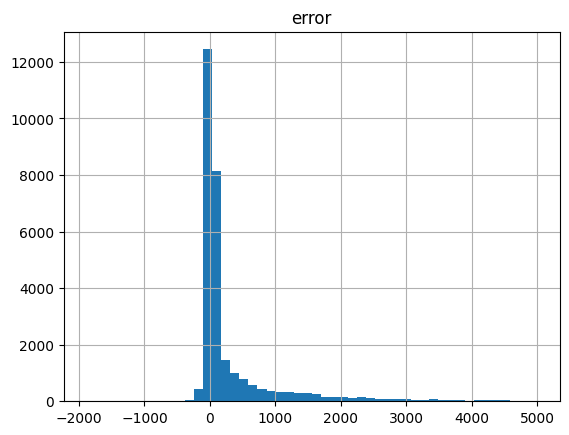

In [34]:
error_df[error_df["error"] < 5000].hist(column="error", bins=50);

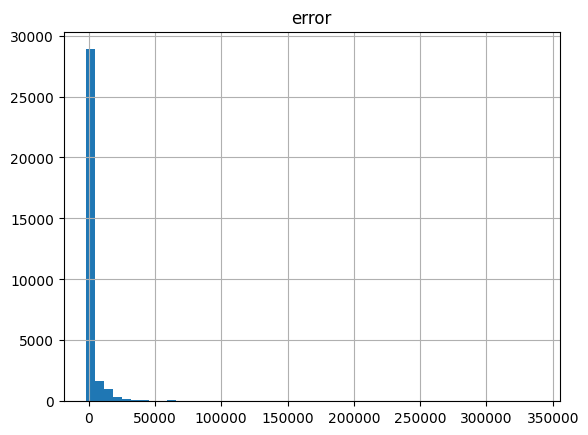

In [35]:
error_df.hist(column="error", bins=50);

In [36]:
error_df["error"].mean(), error_df["error"].std()

(2324.4481046057367, 8142.885825389809)

In [37]:
error_df["error"].median()

60.081011943003205

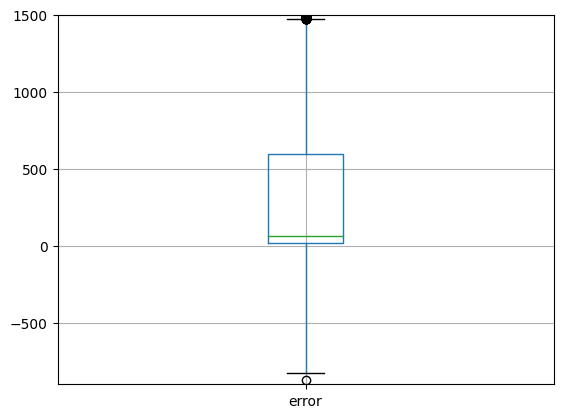

In [38]:
ax = error_df.boxplot(column="error")
ax.set_ylim(-900, 1500);

In [47]:
q25, q50, q75 = error_df["error"].quantile(0.25), \
                error_df["error"].quantile(0.5),  \
                error_df["error"].quantile(0.75)

In [40]:
iqr = q75 - q25
tukey_min, tukey_max = q25 - 1.5 * iqr, q75 + 1.5 * iqr

In [41]:
tukey_min, tukey_max

(-859.6780867668297, 1470.7295796246185)

In [49]:
q25, q50, q75

(14.224788129963372, 60.081011943003205, 596.8267047278254)

In [50]:
error_df[(error_df["error"] >= tukey_min) & (error_df["error"] <= tukey_max)].shape[0]

26702

In [51]:
error_df.shape[0]

32528

In [52]:
error_df.shape[0] - error_df[(error_df["error"] >= tukey_min) & (error_df["error"] <= tukey_max)].shape[0]

5826

In [53]:
5826 / 32528 * 100.0

17.910723069355633

In [43]:
error_df[(error_df["error"] < 250) & (error_df["error"] > -125)].shape[0]

21656

In [44]:
error_df[(error_df["error"] > 250)].shape[0]

10523